In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

print(sns.__version__)

0.13.2


In [36]:
df.tail()

,Load,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction_x,prediction_y,prediction
2018-12-31 19:00:00,203.598065,19,0,4,12,2018,365,31,1,200.355865,200.355865,200.355865
2018-12-31 20:00:00,199.205624,20,0,4,12,2018,365,31,1,198.943405,198.943405,198.943405
2018-12-31 21:00:00,195.061812,21,0,4,12,2018,365,31,1,192.993027,192.993027,192.993027
2018-12-31 22:00:00,189.364071,22,0,4,12,2018,365,31,1,187.390472,187.390472,187.390472
2018-12-31 23:00:00,186.939941,23,0,4,12,2018,365,31,1,185.614365,185.614365,185.614365


In [50]:
df = pd.read_csv('bus_1_load_copy.csv')
start_date = '01-01-2018'
datetime_index = pd.date_range(start=start_date, periods=len(df), freq='h')
df.index = datetime_index

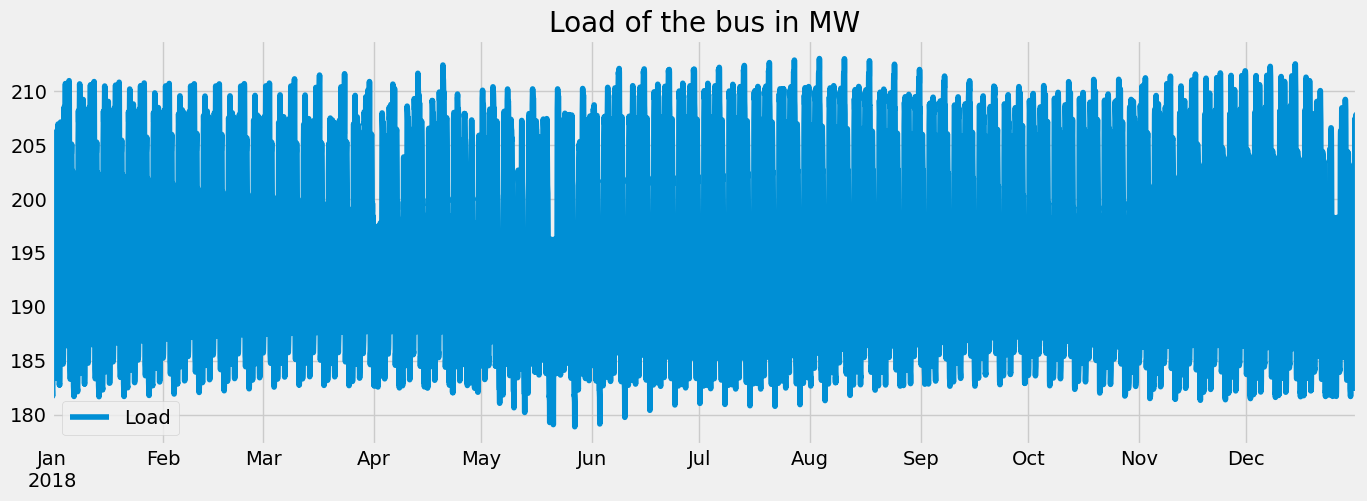

In [51]:
df.plot(style='-', figsize=(15, 5), color=color_pal[0], title='Load of the bus in MW')
plt.show()

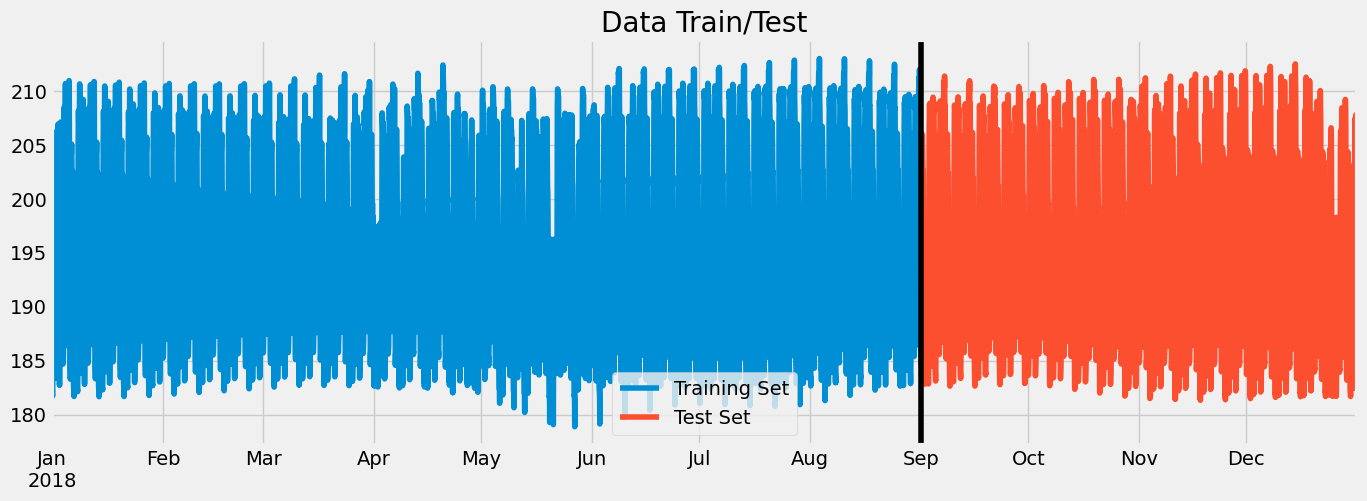

In [48]:
train = df.loc[df.index < '09-01-2018']     # Month-day-year
test = df.loc[df.index >= '09-01-2018']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test')
test.plot(ax=ax, label='Test Set')
ax.axvline('09-01-2018', color='black', ls='-')
ax.legend(['Training Set', 'Test Set'])
plt.show()

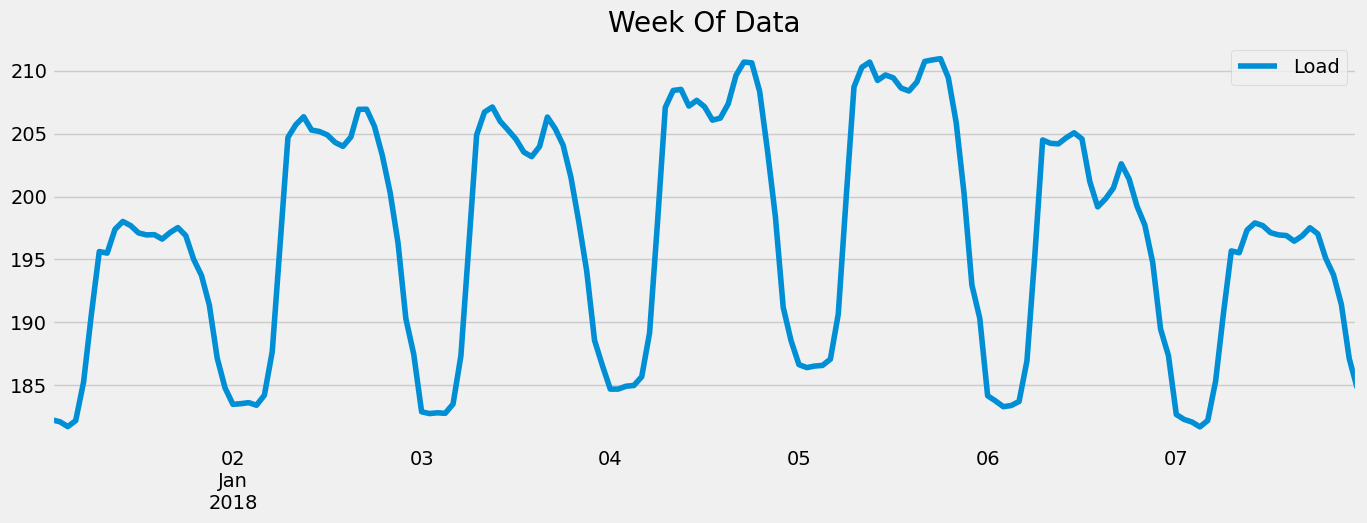

In [49]:
df.loc[(df.index > '01-01-2018') & (df.index < '01-08-2018')].plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [13]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week      # This is not working
    return df

df = create_features(df)

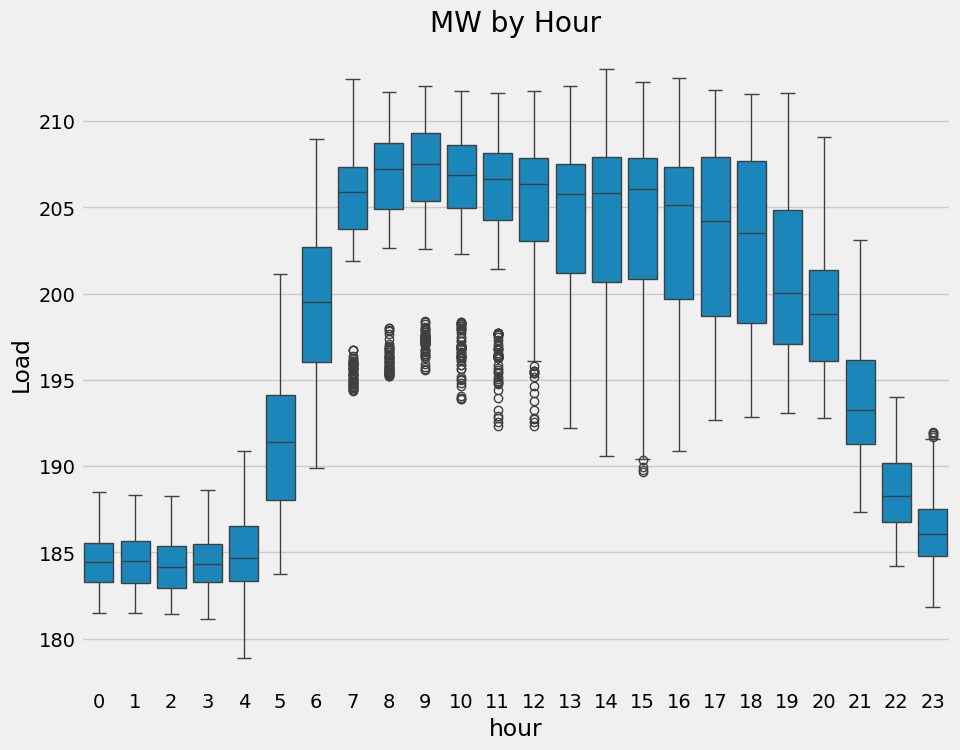

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='Load')
ax.set_title('MW by Hour')
plt.show()

C:\Users\bodhi\AppData\Local\Temp\ipykernel_51592\741897.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='Load', palette='Blues')


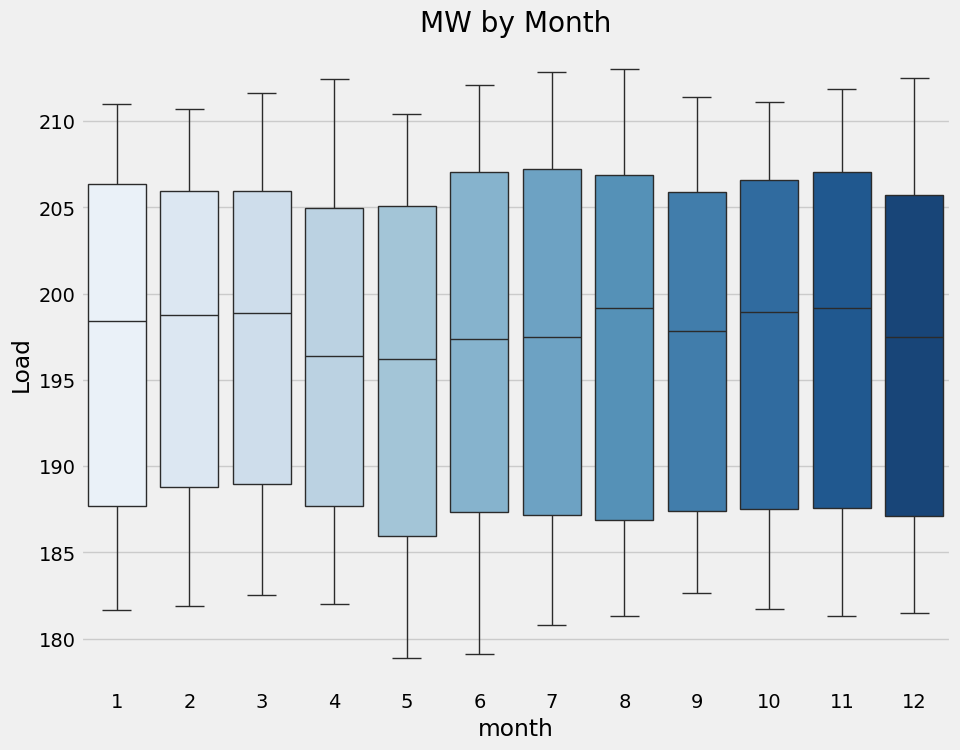

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Load', palette='Blues')
ax.set_title('MW by Month')
plt.show()

In [18]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Load'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [19]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:195.08676	validation_1-rmse:195.25635
[100]	validation_0-rmse:71.53069	validation_1-rmse:71.73816


c:\Users\bodhi\miniconda3\envs\bap_project\Lib\site-packages\xgboost\core.py:160: UserWarning: [18:35:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:26.33318	validation_1-rmse:26.61484
[300]	validation_0-rmse:9.91336	validation_1-rmse:10.17431
[400]	validation_0-rmse:4.16704	validation_1-rmse:4.48133
[500]	validation_0-rmse:2.43549	validation_1-rmse:2.86258
[600]	validation_0-rmse:1.98111	validation_1-rmse:2.58046
[700]	validation_0-rmse:1.82985	validation_1-rmse:2.54261
[734]	validation_0-rmse:1.79841	validation_1-rmse:2.54831


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

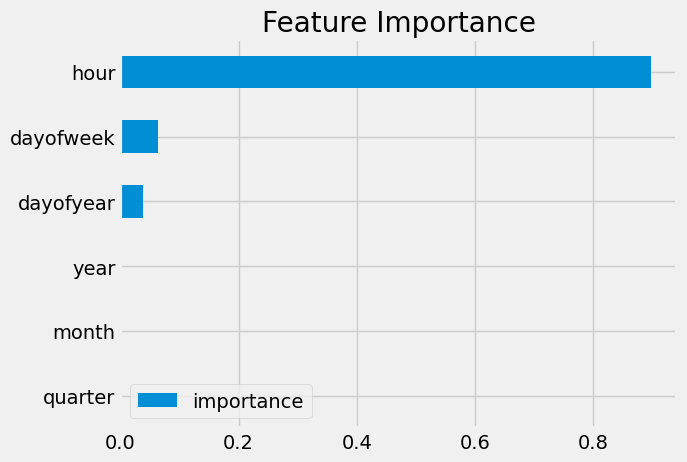

In [20]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

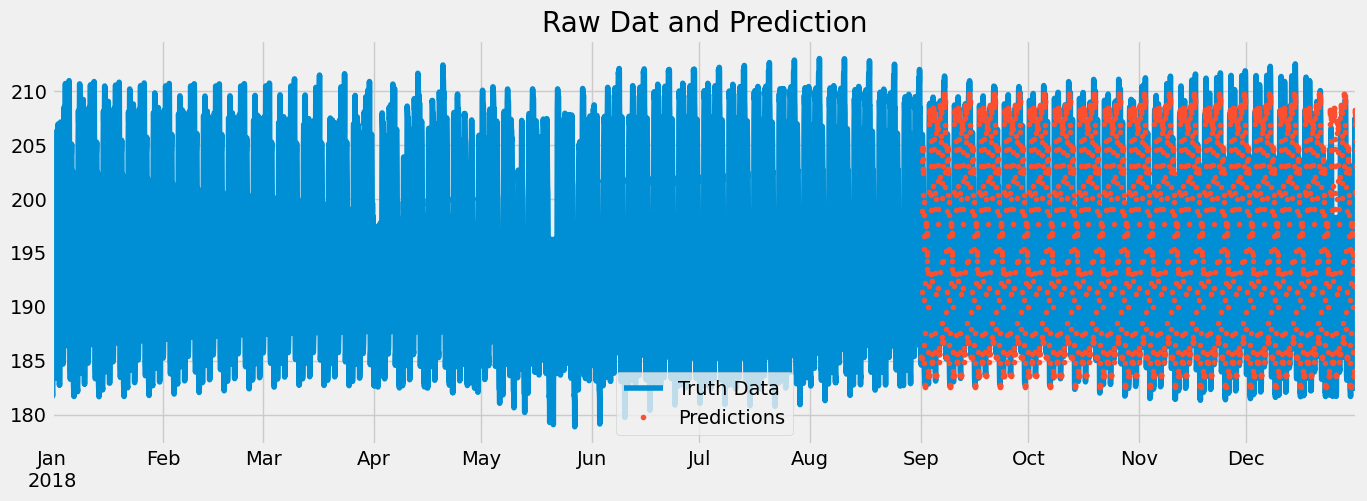

In [23]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Load']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

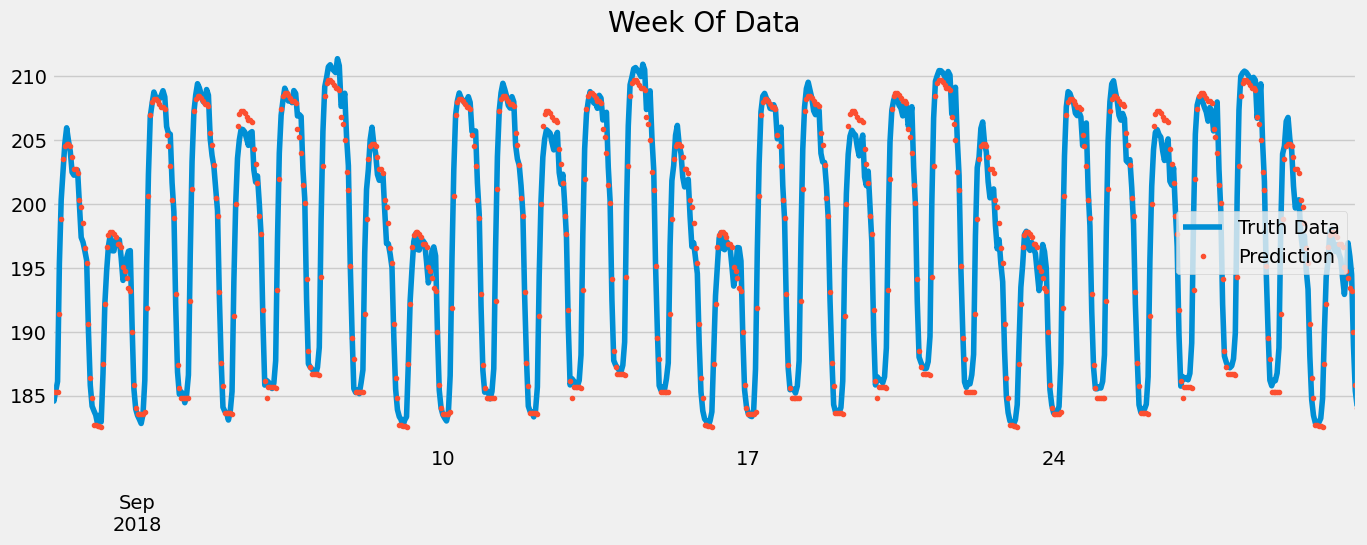

In [32]:
ax = df.loc[(df.index > '09-01-2018') & (df.index < '10-01-2018')]['Load'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '09-01-2018') & (df.index < '10-01-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [26]:
score = np.sqrt(mean_squared_error(test['Load'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 2.54


In [27]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2018-12-25    6.967210
2018-12-26    5.816163
2018-12-24    2.941643
2018-12-27    2.733403
2018-12-20    2.709663
2018-12-17    2.629811
2018-12-10    2.609516
2018-12-03    2.572826
2018-10-13    2.562470
2018-10-20    2.530119
Name: error, dtype: float64